# Introduction

This tutorial demonstrates how to perform a multi-objective neural architecture search (NAS) on a MobileNetV3 one-shot weight-sharing super-network [1] using the Intel® Neural Compressor Dynamic NAS (DyNAS) search approach. 

#### Background
Neural architecture search, the study of automating the discovery of optimal deep neural network architectures for tasks in domains such as computer vision and natural language processing, has seen rapid growth in the machine learning research community. While there have been many recent advancements in NAS, there is still a significant focus on reducing the computational cost incurred when validating discovered architectures by making search more efficient. Evolutionary algorithms, specifically genetic algorithms, have a history of usage in NAS and continue to gain popularity as a highly efficient way to explore the architecture objective space. In this tutorial, we show how evolutionary algorithms [2] can be paired with lightly trained objective predictors in an iterative cycle to accelerate multi-objective architectural exploration. Specifically, we use a bi-level optimization approach [3] denoted as `dynas`. This technique is ~4x more sample efficient than typical one-shot predictor-based NAS approaches. 

#### Super-Networks

The computational overhead of evaluating DNN architectures during the neural architecture search process can be very costly due to the training and validation cycles. To address the training overhead, novel weight-sharing approaches known as one-shot or super-networks have offered a way to mitigate the training overhead by reducing training times from thousands to a few GPU days. These approaches train a task-specific super-network architecture with a weight-sharing mechanism that allows the sub-networks to be treated as unique individual architectures. This enables sub-network model extraction and validation without a separate training cycle. This tutorial offers pre-trained Once-for-All (OFA) super-networks [1] for the image classification on ImageNet-ilsvrc2012 as well as Transformer Language Translation (based on [6]) for the language translation tasks.

#### Methodology

The flow of the DyNAS approach (`approach='dynas'`) is shown in the following figure. Currently, three pre-trained super-network options for the image classification task are provided. In the first phase of the search, a small population (`config.dynas.population`) of sub-networks are randomly sampled and evaluated (validation measurement) to provide the initial training set for the inner predictor loop. After the predictors are trained, a multi-objective evolutionary search (`search_algorithm`) is performed in the predictor objective space. After an extensive search is performed, the best performing sub-network configurations are selected to be the next iteration's validation population. The cycle continues until the search concludes when the user defined evaluation count (`config.dynas.num_evals`) is met. 
   
<br>
<div>
<img src="DyNAS_flow.png" width="750"/>
</div>

## Prerequisites

For released version of Neural Compressor:

In [ ]:
!pip -q install neural_compressor dynast==1.5.2

Alternatievely, if you have a local copy of https://github.com/intel/neural-compressor, you can uncomment and run the code below:

In [ ]:
# import sys
# sys.path.insert(0,'<path to neural compressor>')
# !pip install -qr <path to neural compressor>/requirements.txt
# !pip install -q dynast==1.5.2

## Import Packages

In [ ]:
from neural_compressor.conf.config import NASConfig
from neural_compressor.experimental.nas import NAS

# Configure NAS Algorithm

The `NASConfig` class allows us to define the appropriate parameters for determining how the neural architecture search is performed. Currently, the following multi-objective evolutionary algorithms are supported by the `dynas` approach: 
* `'nsga2'`
* `'age'`

In [ ]:
config = NASConfig(approach='dynas', search_algorithm='nsga2')

### Define Architecture
We currently support pre-trained super-networks:

1. Once-for-All (OFA) super-networks [4] for the image classification task on ImageNet-ilsvrc2012. In the case where the super-network PyTorch model download fails, you can manually copy the pre-trained models from https://github.com/mit-han-lab/once-for-all and place them in the `.torch/ofa_nets` path.
2. Hardware-Aware-Transformers (HAT) supernetwork [6] for language translation task on WMT14 En-De. To run this supernetwork you have to manually download preprocessed dataset from https://github.com/mit-han-lab/hardware-aware-transformers/blob/master/configs/wmt14.en-de/get_preprocessed.sh and pretrained model from https://www.dropbox.com/s/pkdddxvvpw9a4vq/HAT_wmt14ende_super_space0.pt?dl=0
3. BERT Base supernetwork finetuned on the [Stanford Sentiment Treebank](https://huggingface.co/datasets/sst2) dataset. You can download the model from [here](https://github.com/IntelLabs/DyNAS-T/blob/bert/model/models/fine_tuned_bert_sst2.pt) and the script to prepare the SST-2 dataset is available [here](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/LanguageModeling/BERT/data/create_datasets_from_start.sh#L21).

Super-network options (choose 1): 
- `ofa_resnet50` - based on the ResNet50 architecture [4]. Search space of ~$10^{15}$ architectures.
- `ofa_mbv3_d234_e346_k357_w1.0` - based on the MobileNetV3 architecture [5], width multiplier 1.0. Search space of ~$10^{19}$ architectures.
- `ofa_mbv3_d234_e346_k357_w1.2` - based on the MobileNetV3 architecture [5], width multiplier 1.2. Search space of ~$10^{19}$ architectures.  
- `transformer_lt_wmt_en_de` - based on the Transformer architecture [7].
- `bert_base_sst2` - based on the BERT Base architecture, fine-tuned on the [Stanford Sentiment Treebank](https://huggingface.co/datasets/sst2) dataset.

In [ ]:
config.dynas.supernet = 'bert_base_sst2'
config.seed = 42

### Select performance metrics

Performance metric options are as follows. You can use from 1 to 3 performance objectives to guide the search.

Description:
* `'accuracy_top1' or 'bleu' or 'accuracy_sst2'` - ImageNet Top-1 Accuracy (%) (for OFA supetnetworks) and Bleu (for Transformer LT) and accuracy on the SST2 dataset.
* `'macs'` - Multiply-and-accumulates as measured from FVCore. 
* `'latency'` - Latency (inference time) measurement (ms).
* `'params'` - Number of parameters in the model.

In [ ]:
config.dynas.metrics = ['accuracy_sst2', 'macs']

### Search parameters

* `config.dynas.population` - Size of the population for evolutionary/genetic algorithm (50 recommended)
* `config.dynas.num_evals` - Validation measurement count, a higher count comes with greater computational cost but a higher chance of finding optimal sub-networks
* `config.dynas.results_csv_path` - Location of the search (validation measurement) results. This file is also used to provide training data to the metric predictors. 
* `config.dynas.batch_size` - Batch size used during latency measurements.
* `config.dynas.dataset_path` - For OFA it's a path to the imagenet-ilsvrc2012 dataset. This can be obtained at: https://www.image-net.org/download.php; For Transformer LT it's a path to preprocessed WMT EnDe directory (`(...)/data/binary/wmt16_en_de`)
* `config.dynas.supernet_ckpt_path` - Transformer LT only. Path to downloaded pretrained super-network (`HAT_wmt14ende_super_space0.pt` file).

In [ ]:
config.dynas.population = 50
config.dynas.num_evals = 250
config.dynas.results_csv_path = 'results_bert_sst2_macs.csv'
config.dynas.batch_size = 64
config.dynas.dataset_path = '/datasets/SST-2/'  # example
config.dynas.supernet_ckpt_path = '/model/glue_ckpt.pt'

# Perform Search

After the DyNAS configuration parameters are set, the search process can be started. Depending on how many evaluations `config.dynas.num_evals` were defined, the search time can vary from hours to days. 
The search process will populate the `config.dynas.results_csv_path` file and will also return a list of the final iteration's best sub-network population recommondation. 

Note: example search results are provided for the plotting section if you wish to skip this step for now. 

In [ ]:
agent = NAS(config)
results = agent.search()

## Plot Search Results in the Multi-Objective Space

<ipython-input-13-4dc79778ece3>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis_r')


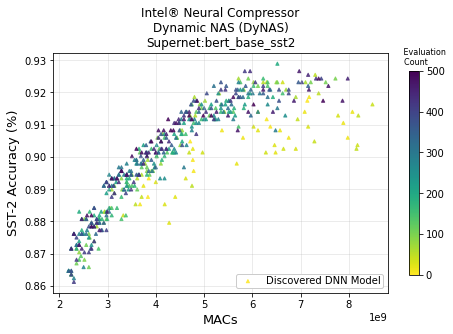

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(figsize=(7,5))

number_of_evals = 500
df_dynas = pd.read_csv('results_bertbase_sst2_macs.csv')[:number_of_evals]
df_dynas.columns = ['config', 'date', 'macs', 'acc']

cm = plt.cm.get_cmap('viridis_r')
count = [x for x in range(len(df_dynas))]

ax.scatter(df_dynas['macs'].values, df_dynas['acc'].values, marker='^', alpha=0.8, c=count,
           cmap=cm, label='Discovered DNN Model', s=10)
ax.set_title(f'Intel® Neural Compressor\nDynamic NAS (DyNAS)\nSupernet:{config.dynas.supernet}')
ax.set_xlabel('MACs', fontsize=13)
ax.set_ylabel('SST-2 Accuracy (%)', fontsize=13)
ax.legend(fancybox=True, fontsize=10, framealpha=1, borderpad=0.2, loc='lower right')
ax.grid(True, alpha=0.3)

# Eval Count bar
norm = plt.Normalize(0, len(df_dynas))
sm = ScalarMappable(norm=norm, cmap=cm)
cbar = fig.colorbar(sm, ax=ax, shrink=0.85)
cbar.ax.set_title("         Evaluation\n  Count", fontsize=8)

fig.tight_layout(pad=2)
plt.show();

# References

[1] Cai, H., Gan, C., & Han, S. (2020). Once for All: Train One Network and Specialize it for Efficient Deployment. ArXiv, abs/1908.09791.   
[2] K. Deb, A. Pratap, S. Agarwal and T. Meyarivan, "A fast and elitist multiobjective genetic algorithm: NSGA-II," in IEEE Transactions on Evolutionary Computation, vol. 6, no. 2, pp. 182-197, April 2002, doi: 10.1109/4235.996017. 
[3] Cummings, D., Sarah, A., Sridhar, S.N., Szankin, M., Muñoz, J.P., & Sundaresan, S. (2022). A Hardware-Aware Framework for Accelerating Neural Architecture Search Across Modalities. ArXiv, abs/2205.10358.   
[4] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep Residual Learning for Image Recognition. 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 770-778.  
[5] Howard, A.G., Sandler, M., Chu, G., Chen, L., Chen, B., Tan, M., Wang, W., Zhu, Y., Pang, R., Vasudevan, V., Le, Q.V., & Adam, H. (2019). Searching for MobileNetV3. 2019 IEEE/CVF International Conference on Computer Vision (ICCV), 1314-1324.    
[6] Wang, H., Wu, Z., Liu, Z., Cai, H., Zhu, L., Gan, C. and Han, S., 2020. Hat: Hardware-aware transformers for efficient natural language processing. arXiv preprint arXiv:2005.14187.    
[7] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A.N., Kaiser, Ł. and Polosukhin, I., 2017. Attention is all you need. Advances in neural information processing systems, 30.